# Neural Style Transfer

__Neural style transfer__ is the process of applying the "style" of a reference image to a specific target image such that in the process, the original "content" of the target image remains unchanged.

__Style__ is defined as colors, patterns and textures present in the reference image

__Content__ is defined as the overall structure and higher level components of the image

The main objective is to retain the "content" of the original target image, while superimposing or adopting the "style" of the reference image on the target image.

In the context of machine learning, we can define the following loss function and work towards minimizing the loss

$$loss = distance(style(Image_{reference}) - style(Image_{generated})) +
       distance(content(Image_{original}) - content(Image_{generated}))$$
       
such that, 

- $distance$ is a norm function like the L2 norm distance
- $style$ is a function to compute representations of style for an image
- $content$ is a function to compute representations of content for an image

The loss function we will try to minimize consists of three parts namely, the content loss, the style loss and the total variation loss which we will be talking about later.

The beauty of deep learning is that by leveraging architectures like deep convolutional neural networks (CNNs), we can mathematically define the above mentioned style and content functions.

We will be using principles of transfer learning in building our system for neural style transfer.

The idea is to use a pre-trained deep CNN, VGG-19 (used by the Visual Geometry Group team in the ImageNet ILSVRC-2014 competition) - refer to Very Deep Convolutional Networks for Large-Scale Image Recognition by K. Simonyan, A. Zisserman, arXiv:1409.1556.

 - We will leverage VGG-19 to help compute layer activations for the reference, target and generated image. 
 - Next, we will use these activations to define specific loss functions mentioned earlier
 - Finally we will use gradient descent to minimize this loss

# Define Image Processing utilities

We need to resize images to make the process easier and do some necessary processing before passing them to the CNN

In [1]:
import numpy as np
from keras.applications import vgg19
from keras.preprocessing.image import load_img, img_to_array


def preprocess_image(image_path, height=None, width=None):
    height = 400 if not height else height
    width = width if width else int(width * height / height)
    img = load_img(image_path, target_size=(height, width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

def deprocess_image(x):
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

Using TensorFlow backend.


# Setup symbolic placeholders for images

In [2]:
from keras import backend as K

# This is the path to the image you want to transform.
TARGET_IMG = 'data/city_road.jpg'
# This is the path to the style image.
REFERENCE_STYLE_IMG = 'data/style2.png'

width, height = load_img(TARGET_IMG).size
img_height = 320
img_width = int(width * img_height / height)


target_image = K.constant(preprocess_image(TARGET_IMG, height=img_height, width=img_width))
style_image = K.constant(preprocess_image(REFERENCE_STYLE_IMG, height=img_height, width=img_width))

# Placeholder for our generated image
generated_image = K.placeholder((1, img_height, img_width, 3))

# Combine the 3 images into a single batch
input_tensor = K.concatenate([target_image,
                              style_image,
                              generated_image], axis=0)

# Setup the VGG-19 CNN model

We do not include the fully-connnected layers since we will not be using the model for classification 

In [3]:
# We will build the VGG19 network with our batch of 3 images as input.
# The model will be loaded with pre-trained ImageNet weights and no fully connected layers.
model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet',
                    include_top=False)

In [4]:
layers = dict([(layer.name, layer.output) for layer in model.layers])
layers

{'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(3, 320, 439, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(3, 320, 439, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(3, 160, 219, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(3, 160, 219, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(3, 160, 219, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(3, 80, 109, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(3, 80, 109, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(3, 80, 109, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(3, 80, 109, 256) dtype=float32>,
 'block3_conv4': <tf.Tensor 'block3_conv4/Relu:0' shape=(3, 80, 109, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool/MaxPool:0' shape=(3, 40, 54, 256) dtype=float32>,
 'bloc

# Define the content loss


In any CNN based model, activations from top layers contain more global and abstract information (high level structures like a face) and bottom layers will contain local information (low level structures like eyes, nose, edges, corners) about the image. We would want to leverage the top layers of a CNN for capturing the right representations for the "content" of an image.

Hence, for the content loss, considering we will be using the pretrained VGG-19 CNN, we can define our loss function as the L2 norm (scaled & squared Euclidean distance) between the activations of a top layer (giving feature representations) computed over the target image and the activations of the same layer computed over the generated image. This assuming we usually get feature representations relevant to the "content" of images from the top layers of a CNN, the generated image is expected to look similar to the the base target image.

In [5]:
def content_loss(base, combination):
    return K.sum(K.square(combination - base))

# Define the style loss


The original paper on neural style transfer, 'A Neural Algorithm of Artistic Style' by Gatys et al. leverages multiple convolutional layers in the CNN (instead of one) to extract meaningful patterns and representations capturing information pertaining to appearance or style from the reference style image across all spatial scales irrespective of the image content.

Staying true to the original paper, we will be leveraging the the __"Gram matrix"__ and compute the same over the feature representations generated by the convolution layer. The Gram matrix , computes the the inner product between the feature maps produced in any given conv layer. The inner products terms are proportional to the covariances of corresponding feature sets and hence captures patterns of correlations between the features of a layer which tend to activate together. These feature correlations helps capture relevant aggregate statistics of the patterns of a particular spatial scale, which correspond to the style, texture and appearance and not the components and objects present in an image.

The style loss is thus defined as the scaled and squared Frobenius norm of the difference between the Gram matrices of the reference style and the generated images. Minimizing this loss tries to make sure that the textures found at different spatial scales in the reference style image will be similar in generated image.

In [6]:
def style_loss(style, combination, height, width):
    
    def build_gram_matrix(x):
        features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
        gram_matrix = K.dot(features, K.transpose(features))
        return gram_matrix

    S = build_gram_matrix(style)
    C = build_gram_matrix(combination)
    channels = 3
    size = height * width
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

# Define the total variation loss

The total variation loss is analogous to regularization loss. This is introduced for ensuring spatial continuity and smoothness in the generated image to avoid noisy and overly pixelated results. The reason being that optimizing only style and content loss generates noisy output  

In [7]:
def total_variation_loss(x):
    a = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, 1:, :img_width - 1, :])
    b = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, :img_height - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

# Building the loss function

In [8]:
# weights for the weighted average loss function
content_weight = 0.025
style_weight = 1.0
total_variation_weight = 1e-4

## set the content and style layers based on VGG architecture

# define function to set layers based on source paper followed
def set_cnn_layers(source='gatys'):
    if source == 'gatys':
        # config from Gatys et al.
        content_layer = 'block5_conv2'
        style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 
                        'block4_conv1', 'block5_conv1']
    elif source == 'johnson':
        # config from Johnson et al.
        content_layer = 'block2_conv2'
        style_layers = ['block1_conv2', 'block2_conv2', 'block3_conv3', 
                        'block4_conv3', 'block5_conv3']
    else:
        # use Gatys config as the default anyway
        content_layer = 'block5_conv2'
        style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 
                        'block4_conv1', 'block5_conv1']
    return content_layer, style_layers

# set the source research paper followed and set the content and style layers
source_paper = 'gatys'
content_layer, style_layers = set_cnn_layers(source=source_paper)

## build the weighted loss function

# initialize total loss
loss = K.variable(0.)

# add content loss
layer_features = layers[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss += content_weight * content_loss(target_image_features,
                                      combination_features)

# add style loss
for layer_name in style_layers:
    layer_features = layers[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features, 
                    height=img_height, width=img_width)
    loss += (style_weight / len(style_layers)) * sl

# add total variation loss
loss += total_variation_weight * total_variation_loss(generated_image)

# Build the optimizer

Our main objective remains to iteratively minimize the loss with the help of an optimization algorithm with the help of our loss function, gradients and an optimization algorithm.

In the paper, the optimization was done using the L-BFGS algorithm which is an optimization algorithm based on quasi-Newton methods which is popularly used for solving non-linear optimization problems and parameter estimation. This method usually converges faster than standard gradient descent. SciPy has an implementation available in `scipy.optimize.fmin_l_bfgs_b(...)`. However limitations include the function being applicable only to flat 1-D vectors unlike 3-D image matrices which we are dealing with and the fact that value of loss function and gradients need to be passed as two separate functions.

We build an `Evaluator` class based on patterns followed by `keras` creator Francois Chollet to compute both loss and gradients values in one pass instead of independent and separate computations. This will return the loss value when called the first time, and will cache the gradients for the next call. Thus it would be more efficient than computing both independently.

In [9]:
# Get the gradients of the generated image wrt the loss
grads = K.gradients(loss, generated_image)[0]

# Function to fetch the values of the current loss and the current gradients
fetch_loss_and_grads = K.function([generated_image], [loss, grads])


class Evaluator(object):

    def __init__(self, height=None, width=None):
        self.loss_value = None
        self.grads_values = None
        self.height = height
        self.width = width

    def loss(self, x):
        assert self.loss_value is None
        x = x.reshape((1, self.height, self.width, 3))
        outs = fetch_loss_and_grads([x])
        loss_value = outs[0]
        grad_values = outs[1].flatten().astype('float64')
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator(height=img_height, width=img_width)

# Run the optimizer

In [10]:
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
import time

result_prefix = 'style_transfer_result_'+TARGET_IMG.split('.')[0]
result_prefix = result_prefix+'_'+source_paper
iterations = 20

# Run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss.
# This is our initial state: the target image.
# Note that `scipy.optimize.fmin_l_bfgs_b` can only process flat vectors.
x = preprocess_image(TARGET_IMG, height=img_height, width=img_width)
x = x.flatten()

for i in range(iterations):
    print('Start of iteration', (i+1))
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x,
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    if (i+1) % 5 == 0 or i == 0:
        # Save current generated image only every 5 iterations
        img = x.copy().reshape((img_height, img_width, 3))
        img = deprocess_image(img)
        fname = result_prefix + '_at_iteration_%d.png' %(i+1)
        imsave(fname, img)
        print('Image saved as', fname)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i+1, end_time - start_time))

Start of iteration 1
Current loss value: 2.4219e+09
Image saved as style_transfer_result_city_road_gatys_at_iteration_1.png
Iteration 1 completed in 506s
Start of iteration 2
Current loss value: 9.58614e+08
Iteration 2 completed in 542s
Start of iteration 3
Current loss value: 6.3843e+08
Iteration 3 completed in 854s
Start of iteration 4
Current loss value: 4.91831e+08
Iteration 4 completed in 727s
Start of iteration 5
Current loss value: 4.03013e+08
Image saved as style_transfer_result_city_road_gatys_at_iteration_5.png
Iteration 5 completed in 878s
Start of iteration 6
Current loss value: 3.52635e+08
Iteration 6 completed in 850s
Start of iteration 7
Current loss value: 3.19245e+08
Iteration 7 completed in 842s
Start of iteration 8
Current loss value: 2.86269e+08
Iteration 8 completed in 902s
Start of iteration 9
Current loss value: 2.64467e+08
Iteration 9 completed in 849s
Start of iteration 10
Current loss value: 2.47614e+08
Image saved as style_transfer_result_city_road_gatys_at_i

# View Results

In [36]:
from skimage import io
from glob import glob
from matplotlib import pyplot as plt

%matplotlib inline

## Example 1: City Road Image with Edtaonisl Style

In [68]:
cr_content_image = io.imread('results/city road/city_road.jpg')
cr_style_image = io.imread('results/city road/style2.png')
cr_iter1 = io.imread('results/city road/style_transfer_result_city_road_gatys_at_iteration_1.png')
cr_iter10 = io.imread('results/city road/style_transfer_result_city_road_gatys_at_iteration_10.png')
cr_iter20 = io.imread('results/city road/style_transfer_result_city_road_gatys_at_iteration_20.png')

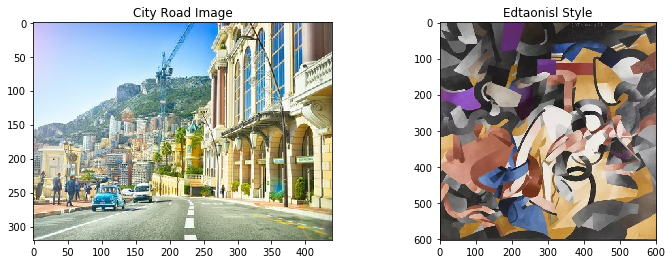

In [69]:
fig = plt.figure(figsize = (12, 4))
ax1 = fig.add_subplot(1,2, 1)
ax1.imshow(cr_content_image)
t1 = ax1.set_title('City Road Image')
ax2 = fig.add_subplot(1,2, 2)
ax2.imshow(cr_style_image)
t2 = ax2.set_title('Edtaonisl Style')

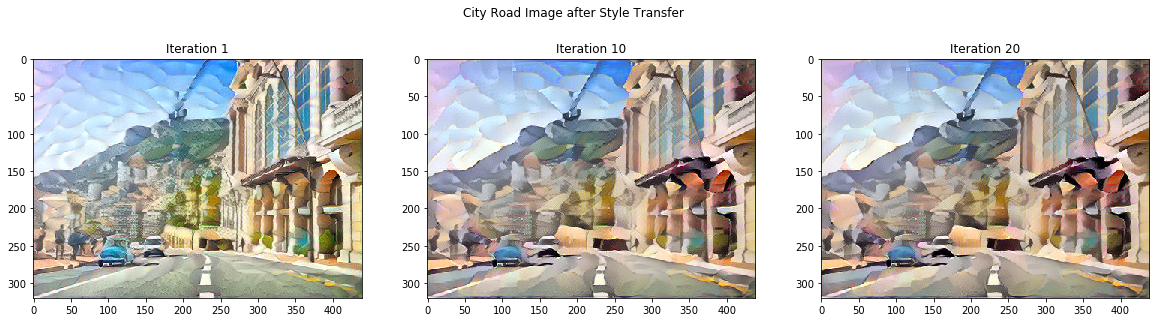

In [70]:
fig = plt.figure(figsize = (20, 5))
ax1 = fig.add_subplot(1,3, 1)
ax1.imshow(cr_iter1)
t1 = ax1.set_title('Iteration 1')
ax2 = fig.add_subplot(1,3, 2)
ax2.imshow(cr_iter10)
t2 = ax2.set_title('Iteration 10')
ax3 = fig.add_subplot(1,3, 3)
ax3.imshow(cr_iter20)
t3 = ax3.set_title('Iteration 20')
t = fig.suptitle('City Road Image after Style Transfer')

## Example 2: Italy Street Image with Wave Style

In [71]:
is_content_image = io.imread('results/italy street/italy_street.jpg')
is_style_image = io.imread('results/italy street/style1.png')
is_iter1 = io.imread('results/italy street/style_transfer_result_italy_street_gatys_at_iteration_1.png')
is_iter10 = io.imread('results/italy street/style_transfer_result_italy_street_gatys_at_iteration_10.png')
is_iter20 = io.imread('results/italy street/style_transfer_result_italy_street_gatys_at_iteration_20.png')

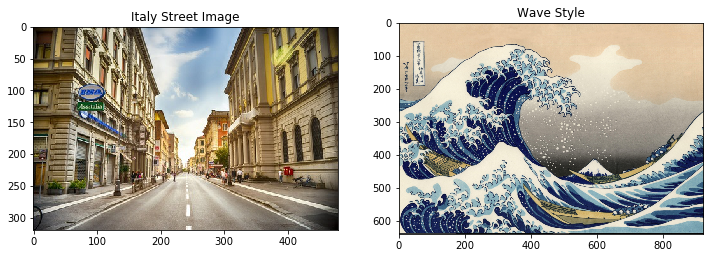

In [72]:
fig = plt.figure(figsize = (12, 4))
ax1 = fig.add_subplot(1,2, 1)
ax1.imshow(is_content_image)
t1 = ax1.set_title('Italy Street Image')
ax2 = fig.add_subplot(1,2, 2)
ax2.imshow(is_style_image)
t2 = ax2.set_title('Wave Style')

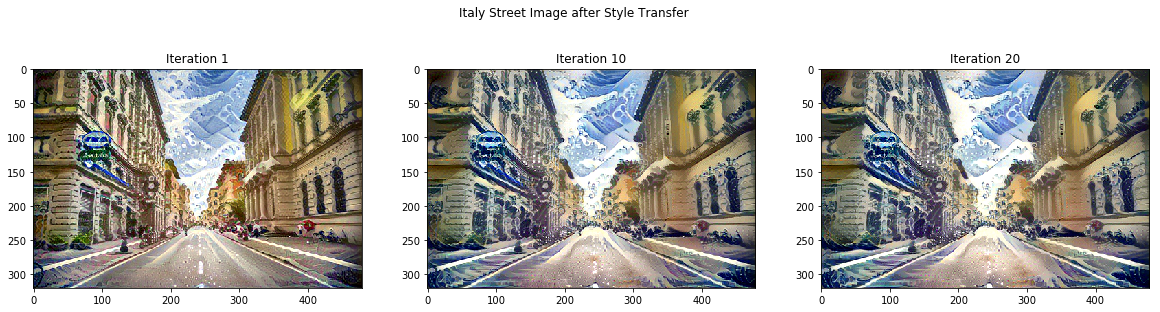

In [73]:
fig = plt.figure(figsize = (20, 5))
ax1 = fig.add_subplot(1,3, 1)
ax1.imshow(is_iter1)
t1 = ax1.set_title('Iteration 1')
ax2 = fig.add_subplot(1,3, 2)
ax2.imshow(is_iter10)
t2 = ax2.set_title('Iteration 10')
ax3 = fig.add_subplot(1,3, 3)
ax3.imshow(is_iter20)
t3 = ax3.set_title('Iteration 20')
t = fig.suptitle('Italy Street Image after Style Transfer')

## Example 3: Tiger Image with Heisenberg Style

In [75]:
tg_content_image = io.imread('results/tiger/tiger.jpeg')
tg_style_image = io.imread('results/tiger/style3.png')
tg_iter1 = io.imread('results/tiger/style_transfer_result_tiger_johnson_at_iteration_1.png')
tg_iter10 = io.imread('results/tiger/style_transfer_result_tiger_johnson_at_iteration_10.png')
tg_iter20 = io.imread('results/tiger/style_transfer_result_tiger_johnson_at_iteration_20.png')

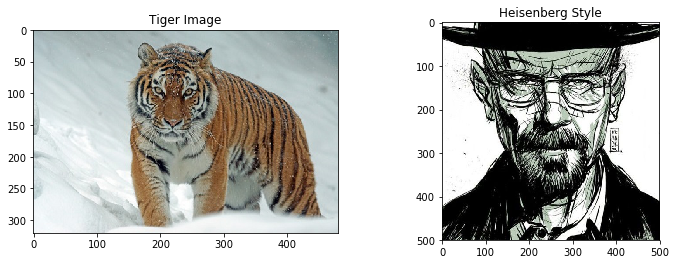

In [76]:
fig = plt.figure(figsize = (12, 4))
ax1 = fig.add_subplot(1,2, 1)
ax1.imshow(tg_content_image)
t1 = ax1.set_title('Tiger Image')
ax2 = fig.add_subplot(1,2, 2)
ax2.imshow(tg_style_image)
t2 = ax2.set_title('Heisenberg Style')

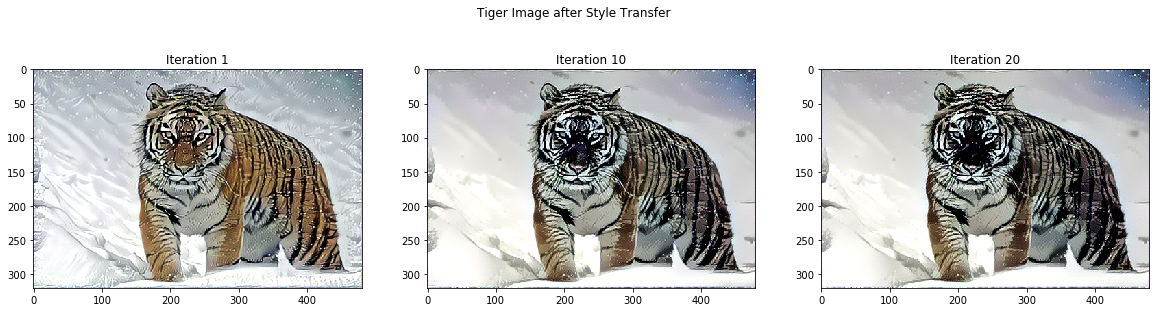

In [77]:
fig = plt.figure(figsize = (20, 5))
ax1 = fig.add_subplot(1,3, 1)
ax1.imshow(tg_iter1)
t1 = ax1.set_title('Iteration 1')
ax2 = fig.add_subplot(1,3, 2)
ax2.imshow(tg_iter10)
t2 = ax2.set_title('Iteration 10')
ax3 = fig.add_subplot(1,3, 3)
ax3.imshow(tg_iter20)
t3 = ax3.set_title('Iteration 20')
t = fig.suptitle('Tiger Image after Style Transfer')